# Actor Critic method in Cart Pole environment 

In [1]:
using ReinforcementLearningBase, ReinforcementLearningEnvironments
using Flux
using Flux:params
using Plots; gr(); 
import StatsBase.sample, StatsBase.Weights

In [2]:
env = CartPoleEnv();

Define Brain:

In [3]:
mutable struct Brain
    β::Float64
    batch_size::Int
    memory_size::Int
    min_memory_size::Int
    memory::Array{Tuple,1}
    policy_net::Chain
    value_net::Chain
    ηₚ::Float64
    ηᵥ::Float64
    opt_state_p::NamedTuple
    opt_state_v::NamedTuple
end

In [4]:
function Brain(env; β = 0.99, ηₚ = 0.001, ηᵥ = 0.005)
    policy_net = Chain(Dense(length(env.state), 24, relu),
                Dense(24, 24, relu),
                Dense(24,length(action_space(env)), identity), softmax)
    opt_state_p = Flux.setup(Adam(ηₚ), policy_net)
    value_net = Chain(Dense(length(env.state), 24, relu),
                Dense(24, 24, relu),
                Dense(24, 1, identity))
    opt_state_v = Flux.setup(Adam(ηᵥ), value_net) 
    Brain(β, 64, 50_000, 1000, [], policy_net, value_net, ηₚ, ηᵥ, opt_state_p, opt_state_v)
end

Brain

and Agent:

In [5]:
mutable struct Agent
    env::AbstractEnv
    brain::Brain
    reward::Float64
end

In [6]:
Agent(env::AbstractEnv) = Agent(env, Brain(env), 0.0)

Agent

Losses:

In [7]:
function actor_loss(m, x, A, γ = 0.001) 
    p = m(x)
    loss = sum(-log.(p .+ 1e-7) .* A)/size(A,1) 
    entropy = sum(-log.(p .+ 1e-7) .* p)/size(A,1)
    return loss - γ * entropy
end  

actor_loss (generic function with 2 methods)

In [8]:
critic_loss(m, x, y, ξ = 0.5) = ξ*Flux.mse(m(x), y)

critic_loss (generic function with 2 methods)

Training functions:

In [9]:
function replay!(agent::Agent)
    x = zeros(Float32,length(agent.env.state), agent.brain.batch_size)
    A = zeros(Float32,length(action_space(agent.env)), agent.brain.batch_size)
    y = zeros(Float32,1, agent.brain.batch_size)
    for (i,step)  in enumerate(sample(agent.brain.memory, agent.brain.batch_size, replace = false))
        s,a,r,s′,v,v′,terminal = step
        terminal ? (R  = r) : (R = r + agent.brain.β * v′)
        adv = R - v
        Adv = zeros(Float32,length(action_space(agent.env)))
        Adv[a] = adv
        x[:, i] .= s
        A[:, i] .= Adv
        y[:, i] .= R
    end
    Flux.train!(actor_loss, agent.brain.policy_net, [(x, A)], agent.brain.opt_state_p)
    Flux.train!(critic_loss, agent.brain.value_net, [(x, y)], agent.brain.opt_state_v)
    #println(actor_loss(x[:, 1], y[:, 1]))
end

function remember!(brain::Brain, step::Tuple)
    length(brain.memory) == brain.memory_size && deleteat!(brain.memory,1)
    push!(brain.memory, step)
end

function forward(brain::Brain, state)
    π = agent.brain.policy_net(state)
    v = agent.brain.value_net(state)[1]
    return π,v
end

forward (generic function with 1 method)

Control Flow:

In [10]:
function step!(agent::Agent, train::Bool)
    s = deepcopy(agent.env.state)
    π,v = forward(agent.brain, s)
    a = sample(1:length(action_space(agent.env)),Weights(π))
    act!(agent.env, a)
    r, s′, terminal = deepcopy(reward(agent.env)), deepcopy(state(agent.env)), 
        deepcopy(is_terminated(agent.env))
    _,v′ = forward(agent.brain, s′)
    agent.reward += r
    remember!(agent.brain, (s,a,r,s′,v,v′,terminal))
    (train && length(agent.brain.memory) > agent.brain.min_memory_size) && replay!(agent)
    terminal 
end

step! (generic function with 1 method)

In [11]:
function run!(agent::Agent, episodes::Int; train::Bool = true,
            plotting::Bool = true, summary::Bool = true)
    ep = 1.0
    sum_rewards = 0.0
    rewards = []
    avg_rewards = []
    while ep ≤ episodes
        plotting && (plot(env); sleep(0.0001))
        if step!(agent, train) 
            reset!(agent.env)
            sum_rewards += agent.reward
            push!(rewards, agent.reward)
            push!(avg_rewards, sum_rewards/ep)
            if summary
                println("episode $(Int(ep)) ends! Reward: $(agent.reward)")
                println("Average reward: $(sum_rewards/ep)")
            end
            ep += 1.0
            agent.reward = 0.0
        end
    end
    return rewards, avg_rewards
end

run! (generic function with 1 method)

In [12]:
agent = Agent(env);

In [13]:
#_, _ = run!(agent,20; train = false, plotting = true);

In [14]:
rewards, avg_rewards = run!(agent,1500; train = true, plotting = false);

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(4 => 24, relu)  # 120 parameters
│   summary(x) = "4-element Vector{Float64}"
└ @ Flux C:\Users\barto\.julia\packages\Flux\htpCe\src\layers\stateless.jl:59


episode 1 ends! Reward: 18.0
Average reward: 18.0
episode 2 ends! Reward: 12.0
Average reward: 15.0
episode 3 ends! Reward: 19.0
Average reward: 16.333333333333332
episode 4 ends! Reward: 15.0
Average reward: 16.0
episode 5 ends! Reward: 17.0
Average reward: 16.2
episode 6 ends! Reward: 12.0
Average reward: 15.5
episode 7 ends! Reward: 26.0
Average reward: 17.0
episode 8 ends! Reward: 10.0
Average reward: 16.125
episode 9 ends! Reward: 11.0
Average reward: 15.555555555555555
episode 10 ends! Reward: 14.0
Average reward: 15.4
episode 11 ends! Reward: 16.0
Average reward: 15.454545454545455
episode 12 ends! Reward: 15.0
Average reward: 15.416666666666666
episode 13 ends! Reward: 23.0
Average reward: 16.0
episode 14 ends! Reward: 24.0
Average reward: 16.571428571428573
episode 15 ends! Reward: 19.0
Average reward: 16.733333333333334
episode 16 ends! Reward: 26.0
Average reward: 17.3125
episode 17 ends! Reward: 13.0
Average reward: 17.058823529411764
episode 18 ends! Reward: 16.0
Average r

episode 281 ends! Reward: 34.0
Average reward: 18.704626334519574
episode 282 ends! Reward: 15.0
Average reward: 18.69148936170213
episode 283 ends! Reward: 9.0
Average reward: 18.657243816254418
episode 284 ends! Reward: 11.0
Average reward: 18.630281690140844
episode 285 ends! Reward: 20.0
Average reward: 18.635087719298244
episode 286 ends! Reward: 37.0
Average reward: 18.6993006993007
episode 287 ends! Reward: 32.0
Average reward: 18.745644599303137
episode 288 ends! Reward: 23.0
Average reward: 18.760416666666668
episode 289 ends! Reward: 33.0
Average reward: 18.80968858131488
episode 290 ends! Reward: 16.0
Average reward: 18.8
episode 291 ends! Reward: 28.0
Average reward: 18.831615120274915
episode 292 ends! Reward: 17.0
Average reward: 18.825342465753426
episode 293 ends! Reward: 14.0
Average reward: 18.808873720136518
episode 294 ends! Reward: 14.0
Average reward: 18.792517006802722
episode 295 ends! Reward: 30.0
Average reward: 18.83050847457627
episode 296 ends! Reward: 12.0

episode 412 ends! Reward: 24.0
Average reward: 18.96359223300971
episode 413 ends! Reward: 28.0
Average reward: 18.98547215496368
episode 414 ends! Reward: 22.0
Average reward: 18.992753623188406
episode 415 ends! Reward: 30.0
Average reward: 19.019277108433734
episode 416 ends! Reward: 15.0
Average reward: 19.009615384615383
episode 417 ends! Reward: 46.0
Average reward: 19.074340527577938
episode 418 ends! Reward: 16.0
Average reward: 19.066985645933013
episode 419 ends! Reward: 17.0
Average reward: 19.062052505966587
episode 420 ends! Reward: 27.0
Average reward: 19.080952380952382
episode 421 ends! Reward: 28.0
Average reward: 19.102137767220903
episode 422 ends! Reward: 8.0
Average reward: 19.075829383886255
episode 423 ends! Reward: 49.0
Average reward: 19.14657210401891
episode 424 ends! Reward: 29.0
Average reward: 19.169811320754718
episode 425 ends! Reward: 56.0
Average reward: 19.256470588235295
episode 426 ends! Reward: 33.0
Average reward: 19.288732394366196
episode 427 en

episode 542 ends! Reward: 22.0
Average reward: 20.075645756457565
episode 543 ends! Reward: 26.0
Average reward: 20.086556169429098
episode 544 ends! Reward: 23.0
Average reward: 20.091911764705884
episode 545 ends! Reward: 27.0
Average reward: 20.1045871559633
episode 546 ends! Reward: 21.0
Average reward: 20.106227106227106
episode 547 ends! Reward: 24.0
Average reward: 20.113345521023767
episode 548 ends! Reward: 26.0
Average reward: 20.124087591240876
episode 549 ends! Reward: 26.0
Average reward: 20.13479052823315
episode 550 ends! Reward: 24.0
Average reward: 20.14181818181818
episode 551 ends! Reward: 25.0
Average reward: 20.150635208711435
episode 552 ends! Reward: 17.0
Average reward: 20.144927536231883
episode 553 ends! Reward: 15.0
Average reward: 20.135623869801083
episode 554 ends! Reward: 29.0
Average reward: 20.15162454873646
episode 555 ends! Reward: 10.0
Average reward: 20.133333333333333
episode 556 ends! Reward: 14.0
Average reward: 20.12230215827338
episode 557 ends

Average reward: 20.68685376661743
episode 678 ends! Reward: 46.0
Average reward: 20.724188790560472
episode 679 ends! Reward: 23.0
Average reward: 20.727540500736378
episode 680 ends! Reward: 13.0
Average reward: 20.716176470588234
episode 681 ends! Reward: 11.0
Average reward: 20.701908957415565
episode 682 ends! Reward: 26.0
Average reward: 20.70967741935484
episode 683 ends! Reward: 15.0
Average reward: 20.701317715959004
episode 684 ends! Reward: 16.0
Average reward: 20.694444444444443
episode 685 ends! Reward: 16.0
Average reward: 20.687591240875914
episode 686 ends! Reward: 10.0
Average reward: 20.67201166180758
episode 687 ends! Reward: 21.0
Average reward: 20.67248908296943
episode 688 ends! Reward: 14.0
Average reward: 20.662790697674417
episode 689 ends! Reward: 32.0
Average reward: 20.67924528301887
episode 690 ends! Reward: 12.0
Average reward: 20.666666666666668
episode 691 ends! Reward: 33.0
Average reward: 20.68451519536903
episode 692 ends! Reward: 31.0
Average reward: 

Average reward: 21.437731196054255
episode 812 ends! Reward: 35.0
Average reward: 21.454433497536947
episode 813 ends! Reward: 13.0
Average reward: 21.444034440344403
episode 814 ends! Reward: 49.0
Average reward: 21.47788697788698
episode 815 ends! Reward: 17.0
Average reward: 21.47239263803681
episode 816 ends! Reward: 10.0
Average reward: 21.458333333333332
episode 817 ends! Reward: 31.0
Average reward: 21.47001223990208
episode 818 ends! Reward: 28.0
Average reward: 21.477995110024448
episode 819 ends! Reward: 25.0
Average reward: 21.48229548229548
episode 820 ends! Reward: 13.0
Average reward: 21.471951219512196
episode 821 ends! Reward: 18.0
Average reward: 21.46772228989038
episode 822 ends! Reward: 25.0
Average reward: 21.472019464720194
episode 823 ends! Reward: 12.0
Average reward: 21.460510328068043
episode 824 ends! Reward: 11.0
Average reward: 21.44781553398058
episode 825 ends! Reward: 36.0
Average reward: 21.465454545454545
episode 826 ends! Reward: 10.0
Average reward: 

Average reward: 21.897872340425533
episode 941 ends! Reward: 22.0
Average reward: 21.89798087141339
episode 942 ends! Reward: 16.0
Average reward: 21.89171974522293
episode 943 ends! Reward: 28.0
Average reward: 21.898197242841995
episode 944 ends! Reward: 15.0
Average reward: 21.890889830508474
episode 945 ends! Reward: 49.0
Average reward: 21.91957671957672
episode 946 ends! Reward: 29.0
Average reward: 21.927061310782243
episode 947 ends! Reward: 15.0
Average reward: 21.919746568109822
episode 948 ends! Reward: 34.0
Average reward: 21.932489451476794
episode 949 ends! Reward: 39.0
Average reward: 21.950474183350895
episode 950 ends! Reward: 35.0
Average reward: 21.96421052631579
episode 951 ends! Reward: 12.0
Average reward: 21.95373291272345
episode 952 ends! Reward: 14.0
Average reward: 21.945378151260503
episode 953 ends! Reward: 17.0
Average reward: 21.9401888772298
episode 954 ends! Reward: 27.0
Average reward: 21.945492662473793
episode 955 ends! Reward: 9.0
Average reward: 21

Average reward: 22.284514925373134
episode 1073 ends! Reward: 14.0
Average reward: 22.276794035414724
episode 1074 ends! Reward: 31.0
Average reward: 22.28491620111732
episode 1075 ends! Reward: 11.0
Average reward: 22.274418604651164
episode 1076 ends! Reward: 9.0
Average reward: 22.262081784386616
episode 1077 ends! Reward: 27.0
Average reward: 22.26648096564531
episode 1078 ends! Reward: 38.0
Average reward: 22.28107606679035
episode 1079 ends! Reward: 32.0
Average reward: 22.290083410565337
episode 1080 ends! Reward: 9.0
Average reward: 22.27777777777778
episode 1081 ends! Reward: 44.0
Average reward: 22.29787234042553
episode 1082 ends! Reward: 28.0
Average reward: 22.303142329020332
episode 1083 ends! Reward: 53.0
Average reward: 22.331486611265003
episode 1084 ends! Reward: 57.0
Average reward: 22.363468634686345
episode 1085 ends! Reward: 27.0
Average reward: 22.36774193548387
episode 1086 ends! Reward: 31.0
Average reward: 22.375690607734807
episode 1087 ends! Reward: 35.0
Ave

episode 1201 ends! Reward: 39.0
Average reward: 22.89758534554538
episode 1202 ends! Reward: 11.0
Average reward: 22.887687188019967
episode 1203 ends! Reward: 50.0
Average reward: 22.910224438902745
episode 1204 ends! Reward: 47.0
Average reward: 22.930232558139537
episode 1205 ends! Reward: 47.0
Average reward: 22.95020746887967
episode 1206 ends! Reward: 53.0
Average reward: 22.975124378109452
episode 1207 ends! Reward: 13.0
Average reward: 22.96685998342999
episode 1208 ends! Reward: 54.0
Average reward: 22.992549668874172
episode 1209 ends! Reward: 11.0
Average reward: 22.982630272952854
episode 1210 ends! Reward: 33.0
Average reward: 22.990909090909092
episode 1211 ends! Reward: 44.0
Average reward: 23.008257638315442
episode 1212 ends! Reward: 31.0
Average reward: 23.014851485148515
episode 1213 ends! Reward: 30.0
Average reward: 23.02061005770816
episode 1214 ends! Reward: 14.0
Average reward: 23.013179571663922
episode 1215 ends! Reward: 43.0
Average reward: 23.02962962962963


Average reward: 23.39652567975831
episode 1325 ends! Reward: 22.0
Average reward: 23.39547169811321
episode 1326 ends! Reward: 27.0
Average reward: 23.398190045248867
episode 1327 ends! Reward: 13.0
Average reward: 23.390354182366238
episode 1328 ends! Reward: 23.0
Average reward: 23.390060240963855
episode 1329 ends! Reward: 30.0
Average reward: 23.395033860045146
episode 1330 ends! Reward: 32.0
Average reward: 23.401503759398498
episode 1331 ends! Reward: 28.0
Average reward: 23.40495867768595
episode 1332 ends! Reward: 47.0
Average reward: 23.42267267267267
episode 1333 ends! Reward: 27.0
Average reward: 23.42535633908477
episode 1334 ends! Reward: 28.0
Average reward: 23.428785607196403
episode 1335 ends! Reward: 9.0
Average reward: 23.41797752808989
episode 1336 ends! Reward: 14.0
Average reward: 23.410928143712574
episode 1337 ends! Reward: 29.0
Average reward: 23.415108451757668
episode 1338 ends! Reward: 18.0
Average reward: 23.411061285500747
episode 1339 ends! Reward: 15.0
Av

Average reward: 23.907649896623017
episode 1452 ends! Reward: 13.0
Average reward: 23.900137741046834
episode 1453 ends! Reward: 45.0
Average reward: 23.91465932553338
episode 1454 ends! Reward: 47.0
Average reward: 23.93053645116919
episode 1455 ends! Reward: 11.0
Average reward: 23.921649484536083
episode 1456 ends! Reward: 155.0
Average reward: 24.011675824175825
episode 1457 ends! Reward: 28.0
Average reward: 24.014413177762524
episode 1458 ends! Reward: 42.0
Average reward: 24.026748971193417
episode 1459 ends! Reward: 54.0
Average reward: 24.04729266620973
episode 1460 ends! Reward: 47.0
Average reward: 24.063013698630137
episode 1461 ends! Reward: 15.0
Average reward: 24.05681040383299
episode 1462 ends! Reward: 24.0
Average reward: 24.056771545827633
episode 1463 ends! Reward: 13.0
Average reward: 24.049213943950786
episode 1464 ends! Reward: 11.0
Average reward: 24.040300546448087
episode 1465 ends! Reward: 41.0
Average reward: 24.0518771331058
episode 1466 ends! Reward: 24.0


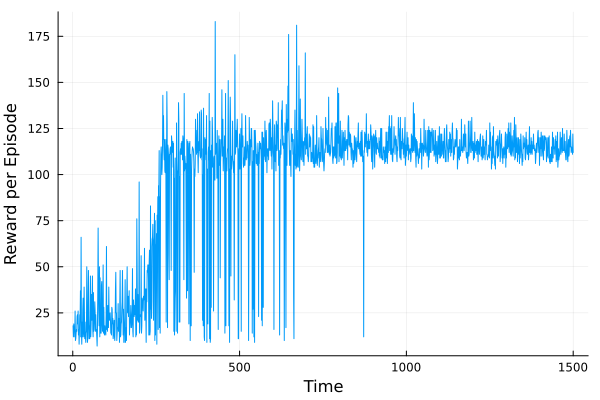

In [15]:
plot(rewards, xlabel = "Time", ylabel = "Reward per Episode", legend = false)

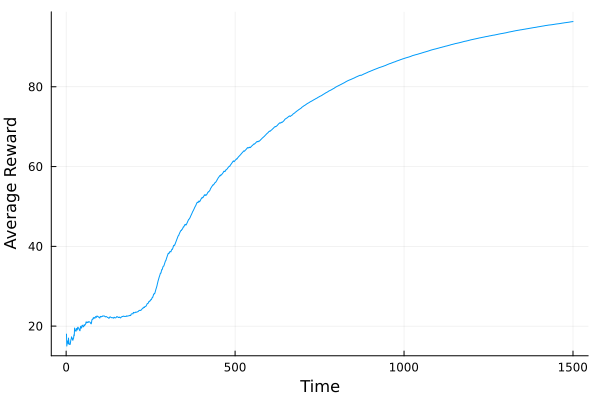

In [16]:
plot(avg_rewards, xlabel = "Time", ylabel = "Average Reward", legend = false)